In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Sequential, Model, Layer, layers, optimizers, losses, metrics, regularizers, callbacks
from matplotlib import pyplot as plt
import mplcyberpunk as mplnk

In [88]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [89]:
from config import Config
from utils.data_loader import DataLoader

In [90]:
train_df = DataLoader().load_train_data()

In [91]:
train_df

,user_id,item_id,rating
0,716,836,4
1,620,422,1
2,547,289,3
3,758,385,4
4,627,197,5
...,...,...,...
79995,336,628,3
79996,749,637,1
79997,758,313,4
79998,380,139,1


In [92]:
plt.style.use('cyberpunk')

In [93]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 5))

    value_counts = df['rating'].value_counts()
    bars = plt.bar(x=value_counts.index, height=value_counts.values)
    percantages = value_counts / value_counts.sum() * 100

    font_dict = {
        'fontweight': 'normal',
        'fontfamily': 'sans-serif',
        'fontsize': 10,
        'color': 'white'
    }

    for bar, percantage in zip(bars, percantages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percantage:.2f}%', ha='center', va='bottom', fontdict=font_dict)

    mplnk.add_bar_gradient(bars)

    plt.xlabel('Rating', fontweight='bold')
    plt.show()

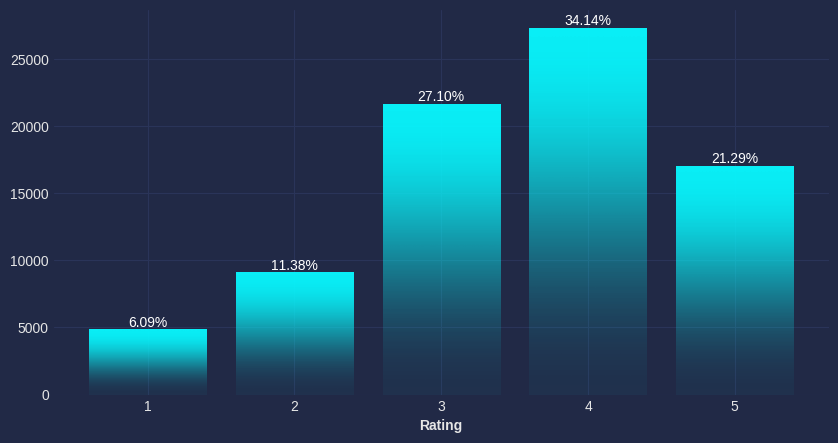

In [94]:
plot_ratings_distribution(train_df)

In [95]:
val_df = DataLoader().load_val_data()

In [96]:
val_df

,user_id,item_id,rating
0,655,911,2
1,200,88,4
2,763,607,4
3,500,714,2
4,690,163,3
...,...,...,...
19995,932,38,2
19996,154,874,3
19997,527,425,4
19998,464,333,4


In [97]:
x_train, x_test, y_train, y_test = train_df.values, val_df.values, train_df['rating'].values, val_df['rating'].values

In [98]:
x_train.shape

(80000, 3)

In [99]:
class MinMaxNormalization(Layer):
    
    def __init__(self, min_val, max_val, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        scalar = lambda x: ((x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))) * (max_val - min_val) + min_val
        self.lambda_layer = layers.Lambda(scalar)
        
    def call(self, inputs):
        return self.lambda_layer(inputs)

In [100]:
class Split(Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, inputs):
        if isinstance(inputs, tuple) or isinstance(inputs, list):
            inputs = tf.stack(inputs, axis=1)
        user_id, item_id, rating = tf.split(inputs, num_or_size_splits=3, axis=1)
        layers.Reshape(target_shape=(1,))(user_id)
        layers.Reshape(target_shape=(1,))(item_id)
        layers.Reshape(target_shape=(1,))(rating)
        return user_id, item_id, rating

In [101]:
class DeepMF(Model):
    
    def __init__(
        self,
        latent_dim:int = 5, 
        num_users:int = Config.Vars.NUM_USERS,
        num_items:int = Config.Vars.NUM_ITEMS,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_users = num_users
        self.num_items = num_items
        self.split = Split(name='split')
        self.rating = layers.Identity(name='rating')
        self.user_embedding = layers.Embedding(self.num_users + 1, self.latent_dim, name='user_embedding')
        self.user_flatten = layers.Flatten(name='user_flatten')
        self.item_embedding = layers.Embedding(self.num_items + 1, self.latent_dim, name='item_embedding')
        self.item_flatten = layers.Flatten(name='item_flatten')
        self.dot = layers.Dot(axes=1, name='dot')
        self.concatenate1 = layers.Concatenate(axis=1, name='concatenate1')
        # self.norm = MinMaxNormalization(min_val=-.25, max_val=.25, name='normalize')
        self.reshape = layers.Reshape(target_shape=(-1,), name='reshape')
        self.concatenate2 = layers.Concatenate(axis=1, name='concatenate2')
    
    def call(self, inputs):
        user_id, item_id, ratings = self.split(inputs)
        user_emb = self.user_embedding(user_id)
        user_emb = self.user_flatten(user_emb)
        item_emb = self.item_embedding(item_id)
        item_emb = self.item_flatten(item_emb)
        rating_vec = self.dot([user_emb, item_emb])
        embeddings = self.concatenate1([user_emb, item_emb])
        norm_ratings = self.rating(ratings)
        # norm_ratings = self.norm(ratings)
        norm_ratings = self.reshape(norm_ratings)
        embedded_data = self.concatenate2([embeddings, norm_ratings])
        return rating_vec, embedded_data
    
    def predict(self, x):
        _, embedded_data = self.call(x)
        return embedded_data
    
    def train_step(self, data):
        inputs, output = data
        
        with tf.GradientTape() as tape:
            rating_vec, _ = self.call(inputs)
            loss = self.compute_loss(y=output, y_pred=rating_vec)
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            'mse_loss': loss,
            **self.compute_metrics(x=inputs[0], y=output, y_pred=rating_vec)
        }
    
    def summary(self):
        model = self.build_graph()
        return model.summary()
    
    def build_graph(self):
        x = (layers.Input(shape=(3,)))
        return Model(inputs=x, outputs=self.call(x))

In [102]:
deepmf = DeepMF()
deepmf.compile(
    optimizer=optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.R2Score()]
)

In [103]:
deepmf.fit(
    [x_train[:, 0], x_train[:, 1], x_train[:, 2]],
    y_train,
    validation_data=([x_test[:, 0], x_test[:, 1], x_test[:, 2]], y_test),
    epochs=10,
    batch_size=32,
    validation_freq=3
)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 860us/step - loss: 0.0000e+00 - mse_loss: 11.5859 - r2_score: -9.5025
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - loss: 0.0000e+00 - mse_loss: 3.2735 - r2_score: -2.4667
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - loss: 0.0000e+00 - mse_loss: 1.4866 - r2_score: -0.3062 - val_loss: 1.2678 - val_r2_score: -0.0027
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - loss: 0.0000e+00 - mse_loss: 1.1082 - r2_score: 0.0873
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - loss: 0.0000e+00 - mse_loss: 0.9812 - r2_score: 0.2193
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step - loss: 0.0000e+00 - mse_loss: 0.9304 - r2_score: 0.2679 - val_loss: 0.9490 - val_r2_score: 0.2494
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 0.0000e+00 - mse_loss: 0.9061 - r2_score: 0.2929
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 0.0000e+00 - mse_loss: 0.8927 - r2_score: 0.3041
Epoch 9

In [104]:
embedded_data = deepmf.predict([x_train[:, 0], x_train[:, 1], x_train[:, 2]])
embedded_data.shape

TensorShape([80000, 11])

In [105]:
@keras.utils.register_keras_serializable(package='Custom', name='GAN')
class GAN(Model):
    
    def __init__(
        self,
        generator: Model,
        discriminator: Model,
        noise_dim: int = 100,
        **kwargs
    ):
        super(GAN, self).__init__(**kwargs)
        self.noise_dim = noise_dim
        self.generator = generator
        self.discriminator = discriminator
    
    def call(self, inputs, training=False):
        noise_vec, input_tensor = inputs
        
        gen_tensor = self.generator(noise_vec, training=True)
        
        real_output = self.discriminator(input_tensor, training=True)
        gen_output = self.discriminator(gen_tensor, training=True)
        
        return gen_tensor, real_output, gen_output
    
    def compile(
        self,
        gen_optimizer: keras.Optimizer,
        disc_optimizer: keras.Optimizer,
        **kwargs
    ):
        super(GAN, self).compile(**kwargs)
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
    
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        _, real_output, gen_output = y_pred
        
        gen_loss = losses.binary_crossentropy(tf.ones_like(gen_output), gen_output)
        disc_loss = losses.binary_crossentropy(tf.ones_like(real_output), real_output) + losses.binary_crossentropy(tf.zeros_like(gen_output), gen_output)
        
        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss
        }
    
    def train_step(self, inputs):
        
        noise_vec = tf.random.normal((tf.shape(inputs)[0], self.noise_dim))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            _, real_output, gen_output = self.call(inputs=(noise_vec, inputs), training=True)
            loss = self.compute_loss(y_pred=[inputs, real_output, gen_output])
        
        gen_grads = gen_tape.gradient(loss['gen_loss'], self.generator.trainable_weights)
        disc_grads = disc_tape.gradient(loss['disc_loss'], self.discriminator.trainable_weights)
        
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))
        
        return {
            'gen_loss': loss['gen_loss'],
            'disc_loss': loss['disc_loss']
        }
    
    def predict(self, x):
        return self.generator(x)
    
    def summary(self, **kwargs):
        model = self.build_graph()
        return model.summary(**kwargs)
    
    def build_graph(self):
        if isinstance(self.discriminator, keras.src.models.Functional):
            input_shape = self.discriminator.layers[1].input.shape[1:]
        else:
            input_shape = self.discriminator.layers[0].input.shape[0:]
        
        input_tensor = layers.Input(shape=input_shape)
        noise_vec = layers.Input(shape=(self.noise_dim,))
        
        return Model(inputs=[noise_vec, input_tensor], outputs=self.call((noise_vec, input_tensor)))

In [106]:
def build_generator():
    noise_dim = 100
    latent_dim = 5
    
    inputs = layers.Input(shape=(noise_dim,), name='gen_input')
    x = layers.Dense(units=10, name='dense_1')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu_1')(x)
    x = layers.BatchNormalization(momentum=0.8, name='batch_norm')(x)
    x = layers.Dense(20, name='dense_2')(x)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu_2')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    outputs = layers.Dense(units=latent_dim * 2 + 1, name='dense3')(x)
    
    return Model(inputs=inputs, outputs=outputs, name='generator')

In [107]:
def build_discriminator():
    latent_dim = 5
    
    inputs = layers.Input(shape=(latent_dim * 2 + 1,), name='disc_input')
    x = layers.Dense(units=4, name='dense4')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu1')(x)
    x = layers.Dense(units=1, name='dense5')(x)
    x = layers.Activation('sigmoid', name='sigmoid')(x)

    return Model(inputs=inputs, outputs=x, name='discriminator')

In [108]:
gan = GAN(generator=build_generator(), discriminator=build_discriminator())
gan.compile(
    gen_optimizer=optimizers.Adam(),
    disc_optimizer=optimizers.Adam()
)

In [109]:
gan.fit(
    x=embedded_data,
    epochs=50,
    batch_size=32,
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - disc_loss: 1.3917 - gen_loss: 0.7331 - loss: 0.0000e+00
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3846 - gen_loss: 0.7400 - loss: 0.0000e+00
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3707 - gen_loss: 0.7045 - loss: 0.0000e+00
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3846 - gen_loss: 0.7415 - loss: 0.0000e+00
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3697 - gen_loss: 0.7001 - loss: 0.0000e+00
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3860 - gen_loss: 0.7097 - loss: 0.0000e+00
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step - disc_loss: 1.3929 - gen_loss: 0.7159 - loss: 0.0000e+00
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - disc_loss: 1.3937 - gen_loss: 0.6993 - loss: 0.0000e+00
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - disc_loss: 1.3862 - gen_loss: 0.6963 - los

In [110]:
gan.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator           │ (None, 11)        │      1,501 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 1)         │         53 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ generator[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,554 (6.07 KB)

 Trainable params: 1,534 (5.99 KB)

 Non-trainable params: 20 (80.00 B)

In [111]:
STD_DEV = 1.5 # You can stablish the fake samples variability by setting this value
noise = np.random.normal(0, STD_DEV, (50000, 100))

In [112]:
augmented = gan.predict(noise).numpy()

In [113]:
augmented[:, -1] = MinMaxNormalization(min_val=-1, max_val=6)(augmented[:, -1]).numpy()

In [114]:
FAKE_SAMPLES = 50000
latent_dim = 5

In [116]:
from sklearn.cluster import KMeans

testing_users = [500, 1000]
testing_items = [1000, 2000]

for K in testing_users:   
    clustering_users = KMeans(n_clusters=K, n_init=1, max_iter= 100, verbose=1)
    cluster_users = clustering_users.fit_predict(augmented[:FAKE_SAMPLES,:latent_dim])  
    np.save('cluster_users' + str(FAKE_SAMPLES) + '_' + str(K), cluster_users)  
    print("end cluster users: " + str(K))

for K in testing_items:   
    clustering_items = KMeans(n_clusters=K, n_init=1, max_iter= 100, verbose=1)
    cluster_items = clustering_items.fit_predict(augmented[:FAKE_SAMPLES,latent_dim:-1])  
    np.save('cluster_items' + str(FAKE_SAMPLES) + '_' + str(K), cluster_items)   
    print("end cluster items: " + str(K))

Initialization complete
Iteration 0, inertia 4406.2958984375.
Iteration 1, inertia 3934.887939453125.
Iteration 2, inertia 3832.455322265625.
Iteration 3, inertia 3782.6552734375.
Iteration 4, inertia 3751.71728515625.
Iteration 5, inertia 3729.848388671875.
Iteration 6, inertia 3714.944580078125.
Iteration 7, inertia 3705.282958984375.
Iteration 8, inertia 3697.497802734375.
Iteration 9, inertia 3691.25732421875.
Iteration 10, inertia 3685.695068359375.
Iteration 11, inertia 3680.91064453125.
Iteration 12, inertia 3676.906005859375.
Iteration 13, inertia 3673.40966796875.
Iteration 14, inertia 3669.392822265625.
Iteration 15, inertia 3665.326416015625.
Iteration 16, inertia 3662.14208984375.
Iteration 17, inertia 3659.882568359375.
Iteration 18, inertia 3657.9482421875.
Iteration 19, inertia 3656.2568359375.
Iteration 20, inertia 3655.134521484375.
Iteration 21, inertia 3654.072998046875.
Iteration 22, inertia 3653.081787109375.
Iteration 23, inertia 3651.915283203125.
Iteration 24, i

In [117]:
for Ku in testing_users:
    cluster_users = np.load('cluster_users' + str(FAKE_SAMPLES) + '_' + str(Ku)+'.npy')
    for Ki in testing_items:
        cluster_items = np.load('cluster_items' + str(FAKE_SAMPLES) + '_' + str(Ki)+'.npy')
        f = open ('synthetic_'+str(FAKE_SAMPLES)+'_'+str(Ku)+'_'+str(Ki)+'.txt','w')
        f.write('user,item,rating\n')
        
        for i in range(FAKE_SAMPLES):
            us = str(cluster_users[i])
            it = str(cluster_items[i])
            ra = augmented[i,-1:][0]
            if ra > 5.:
                ra = 5
            elif ra < 1:
                ra = 1
            else:
                ra = np.round(ra)
            f.write(us + "," + it + "," + str(ra) + "\n")
        f.close()
        print("synthetic dataset " + str(Ku) + ', ' + str(Ki) + " has been created")
      

synthetic dataset 500, 1000 has been created
synthetic dataset 500, 2000 has been created
synthetic dataset 1000, 1000 has been created
synthetic dataset 1000, 2000 has been created


In [118]:
df = pd.read_csv('synthetic_50000_500_1000.txt')

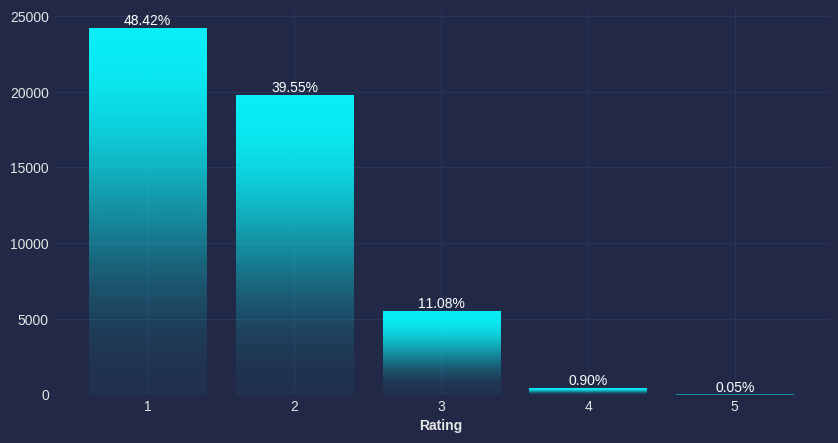

In [119]:
plot_ratings_distribution(df)